In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm.auto import trange

from torchsummary import summary

print(torch.__version__)

1.10.0+cu102


In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(cifar10_train,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(classes))

10


## Visualizing CIFAR10

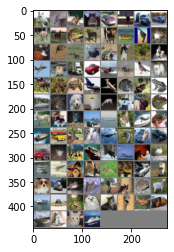

horse  deer   dog truck   car  deer truck   car  deer horse  frog horse   dog  ship plane  frog   cat  bird  deer  bird  frog   cat  bird horse plane   cat truck   car  ship horse  bird   dog horse  frog  frog plane plane   cat  frog  frog  ship  frog   dog plane  deer   cat  deer  frog horse   dog   cat   car  ship   cat  ship  frog  ship   car  bird   cat plane  bird   car   car   car   dog  deer  frog  deer plane horse  bird  ship plane truck   cat  deer   cat   car truck   dog truck  bird plane  bird   cat  frog   dog  ship plane  frog   dog   cat  bird plane truck  ship   cat   cat  ship


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## GoogleNet(Manual)

## 1-1) Basic Module

In [8]:
def conv_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU()
    )
    return model
    
def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model
    

def max_3_1(in_dim,out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(3,1,1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

## 1-2) Inception Module

In [9]:
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output

## 2) Define Model & Optimizer & Loss

In [10]:
# 표와 비교하면서 볼 수 있도록 구현했습니다. 

class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128),
            nn.AvgPool2d(1,1),
            # nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
#         print(out.shape)
        out = out.view(batch_size,-1)
#         print(out.shape)
        out = self.fc_layer(out)
#         print(out.shape)
        return out

In [11]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 VGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = GoogLeNet(base_dim=64).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('layer_1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
))
('layer_2', Sequential(
  (0): inception_module(
    (conv_1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (conv_1_3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_1_5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (max_3_1): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, pad

In [12]:
# # model summary
# summary(model, (3, 32, 32))

In [13]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

  1%|          | 1/100 [00:09<16:25,  9.96s/it]

tensor(1.6233, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 11/100 [01:49<14:38,  9.87s/it]

tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 21/100 [03:28<13:06,  9.96s/it]

tensor(0.2362, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 31/100 [05:07<11:21,  9.87s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 41/100 [06:45<09:48,  9.97s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 51/100 [08:26<08:17, 10.15s/it]

tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 61/100 [10:05<06:23,  9.82s/it]

tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 71/100 [11:43<04:43,  9.77s/it]

tensor(0.0167, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 81/100 [13:23<03:08,  9.94s/it]

tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 91/100 [15:03<01:29, 10.00s/it]

tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [16:31<00:00,  9.91s/it]


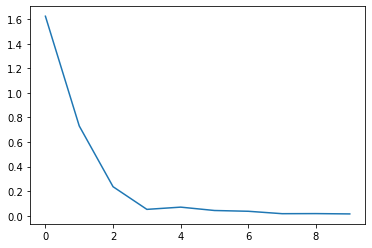

In [14]:
plt.plot(loss_arr)
plt.show()

In [15]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        #print(len(_), _) #values
        #print(len(output_index), output_index) #indices
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 71.98999786376953%
